In [1]:
%%capture
%pip install -r requirement.txt

In [2]:
import numpy as np
import geatpy as ea
import pandas as pd
import random
from datetime import datetime
import timeout_decorator
print(ea.__version__)
pd.set_option('display.max_columns', 500) # show all columns
INTINF = 100000 # int inf

debug = 1 # debug mode

# randomly choose n samples
n = 30000

2.7.0


### PARAMETER INPUT

In [3]:
# boolen
NbvCost = False  # True: max nbv; False: min cost

# float
minTotalNbv = 5000
maxTotalNbv = 100000000

# float
minTotalCost = 5000
maxTotalCost = 100000000

# float
fleetAgeLowBound = [None, 3, 4]
fleetAgeUpBound = [3, 6, 10]
fleetAgeLimit = [0.01, 0.01, 0.01]

# float
OnHireLimit = 0.01

# float
weightedAgeLowBound = [None, 3, 4]
weightedAgeUpBound = [4, 6, 15]
weightedAgeLimit = [0.01, 0.01, 0.01]

# string
productType = ['D20', 'D4H', 'R4H']
# float
productLimit = [0.01, 0.01, 0.01]

# string
lesseeType = ['MSC', 'ONE', 'HAPAG']
# float
lesseeLimit = [0.9, 0.9, 0.9]

# string
contractType = ['LT', 'LE', 'LF']
# float
contractLimit = [0.01, 0.01, 0.01]

### READ DATA
TODO: read data from GP

In [4]:
rawData = pd.read_excel(io='./FCI ANZ (2022-07-08) (NBV as at 30 Jun 2022)_v2.xlsx', sheet_name='Raw (portfolio)', engine='openpyxl')
rawData = rawData.iloc[:30000, :61]

In [5]:
data = rawData.sample(n)
print(data.shape)
data.sample(3)

(1000, 61)


,Business Unit (Contract),Business Unit Am,Unit Id Fz,Cost,Po Num Fz,Mfr Dt Fz,Asset Id,Pool Fz,Product,Birth Unit Id Fz,Owner,Teu Fz,Ceu Fz,Contract Cust Id,Contract Num,Contract Dt,Contract Expiration Dt,Contract Lease Type,Contract Currency,Exchange Rate,Per Diem Rate (Max),Per Diem Rate (Max) in USD,Contract Rate Type (Min),Per Diem Rate (Min),Per Diem Rate (Min) in USD,Buy Out Amt Fz,Monthly Depr,Depre adjustment,Nbv,Life Status Fz,Billing Status Fz,Move Status Fz,Move Type Fz,Inv Status Fz,Fleet Year Fz,Financing Cd,Asset Status,Lessor,Remaining Lease Term,Age x CEU,RML x CEU,Mfr Year,Reserve Code Fz,Remaining Lease Term(C),RML x CEU(C),Chk on RML validity(HAPAG),Expiry year,Expiry month,Chk on RML validity(12 YR),Planned,Entity,Correct CEU,NP year,NBV check,age at drawdown X CEU,RML at drawdown X CEU,category,string,filter 2017 contracts,contract units,filter no. of units
3198,FZOPS,DF3RM,FDCU0048555,3682.0,DFIC-FL-1801,2/28/2018,1121539.0,DFC3,D4H,FDCU0048555,Dong Fang,2.0,1.7,MSC,LT-MSC-35B,2018-03-01,2032-07-31,LT,USD,1.0,1.07,1.07,ST,0.39,0.39,0.0,-15.42,0.681,2917.310,AC,ON,GO,RLI,AVA,4.33,NaN,I,FUSBI,10.09589,7.361,17.163014,2018.0,F - OL / < 8 yrs,10.09589,17.163014,0.00000,2032.0,7.0,14.42589,FCI ANZ 100M,FCI,1.7,2018 NP,Reasonable,8.637164,15.886849,from ANZ portfolio,LT-MSC-35BD4H,NaN,5621.0,1.0
25510,FZOPS,DF3RM,FBIU0319608,2262.0,CIMC-FL-1804,3/21/2018,1182306.0,DFC3,D20,FBIU0319608,Dong Fang,1.0,1.0,ONE,LE-ONE-01,2018-02-01,2026-10-14,LE,USD,1.0,0.69,0.69,FA,0.69,0.69,0.0,-8.23,0.604,1900.275,AC,ON,GO,RLI,AVA,4.27,NaN,I,FUSBI,4.29589,4.270,4.295890,2018.0,F - OL / < 8 yrs,4.29589,4.295890,0.00000,2026.0,10.0,8.56589,CNIC,FCI,1.0,2018 NP,Reasonable,5.020685,3.545205,from available portfolio,LE-ONE-01D20,NaN,4991.0,1.0
1866,FZOPS,DF3RM,FSCU7169497,3832.0,CIMC-FL-1801,12/18/2017,1070400.0,DFC3,D4H,FSCU7169497,Dong Fang,2.0,1.7,HAPAG,LF-HAPAG-09,2017-11-01,2030-01-31,LF,USD,1.0,1.11,1.11,FR,0.61,0.61,0.0,-16.29,0.688,2981.798,AC,ON,GO,RLI,AVA,4.53,NaN,I,FUSBI,7.59726,7.701,12.915342,2017.0,F - OL / < 8 yrs,7.47000,12.699000,-0.12726,2030.0,1.0,12.00000,FCI ANZ 100M,FCI,1.7,2018 NP,Reasonable,8.977164,11.422836,from ANZ portfolio,LF-HAPAG-09D4H,NaN,2516.0,1.0


### DATA PREPARATION

#### Container Age

Assign to `FleetAge1`, `FleetAge2`, `FleetAge3`

In [6]:
def SelectFleetAge(age, i):
    # check input
    if fleetAgeLowBound[i] is None:
        fleetAgeLowBound[i] = -float('inf')
    if fleetAgeUpBound[i] is None:
        fleetAgeUpBound[i] = float('inf')
        
    if fleetAgeLowBound[i] <= age < fleetAgeUpBound[i]:
        age = 1
    else:
        age = 0
    return age

data['FleetAge1'] = data.apply(lambda x: SelectFleetAge(x['Fleet Year Fz'], 0), axis=1)
data['FleetAge2'] = data.apply(lambda x: SelectFleetAge(x['Fleet Year Fz'], 1), axis=1)
data['FleetAge3'] = data.apply(lambda x: SelectFleetAge(x['Fleet Year Fz'], 2), axis=1)

#### Status

Assign new column `Status`

In [7]:
def SelectStatus(status):
    if status == 'ON':
        status = 1
    else:
        status = 0
    return status

data['Status'] = data.apply(lambda x: SelectStatus(x['Billing Status Fz']), axis=1)

#### Weighted Age

Assign new column `WeightedAge1`, `WeightedAge2`, `WeightedAge3`

In [8]:
def SelectWeightedAge(age, i):
    # check input
    if weightedAgeLowBound[i] is None:
        weightedAgeLowBound[i] = -float('inf')
    if weightedAgeUpBound[i] is None:
        weightedAgeUpBound[i] = float('inf')
        
    if weightedAgeLowBound[i] <= age < weightedAgeUpBound[i]:
        age = 1
    else:
        age = 0
    return age

data['WeightedAge1'] = data.apply(lambda x: SelectWeightedAge(x['Age x CEU'], 0), axis=1)
data['WeightedAge2'] = data.apply(lambda x: SelectWeightedAge(x['Age x CEU'], 1), axis=1)
data['WeightedAge3'] = data.apply(lambda x: SelectWeightedAge(x['Age x CEU'], 2), axis=1)

#### Product

Assign new column `ProductType1`, `ProductType2`, `ProductType3`

In [9]:
def SelectProductType(product, i):
    if product == productType[i]:
        product = 1
    else:
        product = 0
    return product

data['ProductType1'] = data.apply(lambda x: SelectProductType(x['Product'], 0), axis=1)
data['ProductType2'] = data.apply(lambda x: SelectProductType(x['Product'], 1), axis=1)
data['ProductType3'] = data.apply(lambda x: SelectProductType(x['Product'], 2), axis=1)

#### Lessee

Assign new column `Lessee1`, `Lessee2`, `Lessee3`

In [10]:
def SelectLessee(lessee, i):
    if lessee == lesseeType[i]:
        lessee = 1
    else:
        lessee = 0
    return lessee

data['Lessee1'] = data.apply(lambda x: SelectLessee(x['Contract Cust Id'], 0), axis=1)
data['Lessee2'] = data.apply(lambda x: SelectLessee(x['Contract Cust Id'], 1), axis=1)
data['Lessee3'] = data.apply(lambda x: SelectLessee(x['Contract Cust Id'], 2), axis=1)

#### Contract Type

Assign new column `ContractType1`, `ContractType2`, `ContractType3`

In [11]:
def SelectContractType(contract, i):
    if contract == contractType[i]:
        contract = 1
    else:
        contract = 0
    return contract

data['ContractType1'] = data.apply(lambda x: SelectContractType(x['Contract Lease Type'], 0), axis=1)
data['ContractType2'] = data.apply(lambda x: SelectContractType(x['Contract Lease Type'], 1), axis=1)
data['ContractType3'] = data.apply(lambda x: SelectContractType(x['Contract Lease Type'], 2), axis=1)

### SAVE DATA

In [12]:
if debug:
    data.to_csv('prepared_data_demo.csv')

In [13]:
if debug:
    data = pd.read_csv('./prepared_data_demo.csv')
data.sample(3)

,Unnamed: 0,Business Unit (Contract),Business Unit Am,Unit Id Fz,Cost,Po Num Fz,Mfr Dt Fz,Asset Id,Pool Fz,Product,Birth Unit Id Fz,Owner,Teu Fz,Ceu Fz,Contract Cust Id,Contract Num,Contract Dt,Contract Expiration Dt,Contract Lease Type,Contract Currency,Exchange Rate,Per Diem Rate (Max),Per Diem Rate (Max) in USD,Contract Rate Type (Min),Per Diem Rate (Min),Per Diem Rate (Min) in USD,Buy Out Amt Fz,Monthly Depr,Depre adjustment,Nbv,Life Status Fz,Billing Status Fz,Move Status Fz,Move Type Fz,Inv Status Fz,Fleet Year Fz,Financing Cd,Asset Status,Lessor,Remaining Lease Term,Age x CEU,RML x CEU,Mfr Year,Reserve Code Fz,Remaining Lease Term(C),RML x CEU(C),Chk on RML validity(HAPAG),Expiry year,Expiry month,Chk on RML validity(12 YR),Planned,Entity,Correct CEU,NP year,NBV check,age at drawdown X CEU,RML at drawdown X CEU,category,string,filter 2017 contracts,contract units,filter no. of units,FleetAge1,FleetAge2,FleetAge3,Status,WeightedAge1,WeightedAge2,WeightedAge3,ProductType1,ProductType2,ProductType3,Lessee1,Lessee2,Lessee3,ContractType1,ContractType2,ContractType3
441,19669,FZOPS,DF3RM,FDCU0619994,3849.0,CIMC-FL-1804,4/6/2018,1212847.0,DFC3,D4H,FDCU0619994,Dong Fang,2.0,1.7,ONE,LE-ONE-01,2018-02-01,2026-10-14,LE,USD,1.0,1.17,1.17,FA,1.17,1.17,0.0,-16.39,0.663,3123.45,AC,ON,GO,RLI,AVA,4.23,NaN,I,FUSBI,4.29589,7.191,7.303014,2018.0,F - OL / < 8 yrs,4.29589,7.303014,0.00000,2026.0,10.0,8.52589,CNIC,FCI,1.7,2018 NP,Reasonable,8.467164,6.026849,from available portfolio,LE-ONE-01D4H,NaN,2539.0,1.0,0,1,1,1,0,0,1,0,1,0,0,1,0,0,1,0
102,26147,FZOPS,DF3RM,FBIU0317035,2262.0,CIMC-FL-1804,3/21/2018,1182049.0,DFC3,D20,FBIU0317035,Dong Fang,1.0,1.0,ONE,LE-ONE-01,2018-02-01,2026-10-14,LE,USD,1.0,0.69,0.69,FA,0.69,0.69,0.0,-8.23,0.610,1884.21,AC,ON,GO,RLI,AVA,4.27,NaN,I,FUSBI,4.29589,4.270,4.295890,2018.0,F - OL / < 8 yrs,4.29589,4.295890,0.00000,2026.0,10.0,8.56589,CNIC,FCI,1.0,2018 NP,Reasonable,5.020685,3.545205,from available portfolio,LE-ONE-01D20,NaN,4991.0,1.0,0,1,1,1,0,1,1,1,0,0,0,1,0,0,1,0
587,27849,FZOPS,DF3RM,FDCU0193907,3682.0,DFIC-FL-1801,1/3/2018,1103074.0,DFC3,D4H,FDCU0193907,Dong Fang,2.0,1.7,HAPAG,LF-HAPAG-09,2017-11-01,2030-01-31,LF,USD,1.0,1.11,1.11,FR,0.61,0.61,0.0,-15.40,0.689,2869.54,AC,ON,GO,RLI,AVA,4.49,NaN,I,FUSBI,7.59726,7.633,12.915342,2018.0,F - OL / < 8 yrs,7.51000,12.767000,-0.08726,2030.0,1.0,12.00000,CNIC,FCI,1.7,2018 NP,Reasonable,8.909164,11.490836,from available portfolio,LF-HAPAG-09D4H,NaN,2516.0,1.0,0,1,1,1,0,0,1,0,1,0,0,0,1,0,0,1


### Model Part

In [14]:
nbv = data['Nbv'].to_numpy().reshape(n, 1)
cost = data['Cost'].to_numpy().reshape(n, 1)
fleetAge = np.stack([data['FleetAge1'].to_numpy(),
                     data['FleetAge2'].to_numpy(),
                     data['FleetAge3'].to_numpy()]).reshape(3, n, 1)
status = data['Status'].to_numpy().reshape(n, 1)
weightedAge = np.stack([data['WeightedAge1'].to_numpy(),
                        data['WeightedAge2'].to_numpy(),
                        data['WeightedAge3'].to_numpy()]).reshape(3, n, 1)
productType = np.stack([data['ProductType1'].to_numpy(),
                        data['ProductType2'].to_numpy(),
                        data['ProductType3'].to_numpy()]).reshape(3, n, 1)
lessee = np.stack([data['Lessee1'].to_numpy(),
                   data['Lessee2'].to_numpy(),
                   data['Lessee3'].to_numpy()]).reshape(3, n, 1)
contractType = np.stack([data['ContractType1'].to_numpy(),
                         data['ContractType2'].to_numpy(),
                         data['ContractType3'].to_numpy(),]).reshape(3, n, 1)
if debug:
    print('nbv shape: ', nbv.shape)
    print('cost shape:', cost.shape)
    print('fleetAge shape: ', fleetAge.shape)
    print('status shape:', status.shape)
    print('weightedAge shape:', weightedAge.shape)
    print('productType shape:', productType.shape)
    print('lessee shape:', lessee.shape)
    print('contractType shape:', contractType.shape)

nbv shape:  (1000, 1)
cost shape: (1000, 1)
fleetAge shape:  (3, 1000, 1)
status shape: (1000, 1)
weightedAge shape: (3, 1000, 1)
productType shape: (3, 1000, 1)
lessee shape: (3, 1000, 1)
contractType shape: (3, 1000, 1)


#### Constraints

`x`: np.array, size=num_of_container. `x[i]=1` stands for $i^{th}$ container is selected; `x[i]=0` stands for $i^{th}$ container is not selected.

1. minTotalNbv <= Total NBV <= maxTotalNbv
    
2. minTotalCost <= Total Cost <= maxTotalCost
    
3. Container Age >=
    
4. Status:

    1. OnHire >= OnHireLimit

5. Weighted Age >=

6. Product >=
    
7. Lessee <=
    
8. Contract Type >= 


#### Objective

1. min Cost: `Vars @ cost`

2. max Nbv: `Vars @ nbv`

#### Define Problem
Define objective function and constraint functions

In [15]:
@timeout_decorator.timeout(30*60) # timeout in 30 minute
def DEMO():
    class MyProblem(ea.Problem):
        def __init__(self):
            name ='MyProblem'
            M = 1
            maxormins = [-1 if NbvCost else 1] # -1: max, 1: min
            Dim = n # num of variables
            varTypes = [1] * Dim # integers: 0 or 1
            lb = [0] * Dim # low bound
            ub = [1] * Dim # up bound
            lbin = [1] * Dim # low bound include
            ubin = [1] * Dim # up bound include
            ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb,ub, lbin, ubin)
            
        def aimFunc(self, pop):
            Vars = pop.Phen
            
            # objective function
            pop.ObjV = Vars @ nbv if NbvCost else Vars @ cost

            numSelectedContainer = Vars.sum(axis=1, keepdims=True)
            CVList = []
            # NBV
            if minTotalNbv is not None:
                CVList.append(-(Vars @ nbv - minTotalNbv))
            if maxTotalNbv is not None:
                CVList.append(Vars @ nbv - maxTotalNbv)
            # Cost
            if minTotalCost is not None:
                CVList.append(-(Vars @ cost - minTotalCost))
            if maxTotalCost is not None:
                CVList.append(Vars @ cost - maxTotalCost)
            # Container age
            if fleetAgeLimit[0] is not None:
                CVList.append(-((Vars @ fleetAge[0]) / numSelectedContainer - fleetAgeLimit[0]))
            if fleetAgeLimit[1] is not None:
                CVList.append(-((Vars @ fleetAge[1]) / numSelectedContainer - fleetAgeLimit[1]))
            if fleetAgeLimit[2] is not None:
                CVList.append(-((Vars @ fleetAge[2]) / numSelectedContainer - fleetAgeLimit[2]))
            # Status
            if OnHireLimit is not None:
                CVList.append(-((Vars @ status) / numSelectedContainer - OnHireLimit))
            # Weighted age
            if weightedAgeLimit[0] is not None:
                CVList.append(-((Vars @ weightedAge[0]) / numSelectedContainer - weightedAgeLimit[0]))
            if weightedAgeLimit[1] is not None:
                CVList.append(-((Vars @ weightedAge[1]) / numSelectedContainer - weightedAgeLimit[1]))
            if weightedAgeLimit[2] is not None:
                CVList.append(-((Vars @ weightedAge[2]) / numSelectedContainer - weightedAgeLimit[2]))
            # Product
            if productLimit[0] is not None:
                CVList.append(-((Vars @ productType[0]) / numSelectedContainer - productLimit[0]))
            if productLimit[1] is not None:
                CVList.append(-((Vars @ productType[1]) / numSelectedContainer - productLimit[1]))
            if productLimit[2] is not None:
                CVList.append(-((Vars @ productType[2]) / numSelectedContainer - productLimit[2]))
            # Lessee
            if lesseeLimit[0] is not None:
                CVList.append((Vars @ lessee[0]) / numSelectedContainer - lesseeLimit[0])
            if lesseeLimit[1] is not None:
                CVList.append((Vars @ lessee[1]) / numSelectedContainer - lesseeLimit[1])
            if lesseeLimit[2] is not None:
                CVList.append((Vars @ lessee[2]) / numSelectedContainer - lesseeLimit[2])
            # Contract type
            if contractLimit[0] is not None:
                CVList.append(-((Vars @ contractType[0]) / numSelectedContainer - contractLimit[0]))
            if contractLimit[1] is not None:
                CVList.append(-((Vars @ contractType[1]) / numSelectedContainer - contractLimit[1]))
            if contractLimit[2] is not None:
                CVList.append(-((Vars @ contractType[2]) / numSelectedContainer - contractLimit[2]))
                
            # constraints functions
            pop.CV = np.hstack(CVList)

#     class My_soea_DE_best_1_L_templet(ea.soea_DE_best_1_L_templet):
#         def terminated(self, pop):
#             self.stat(pop)
#             if self.passTime >= self.MAXTIME:
#                 return True
#             if self.currentGen + 1 >= self.MAXGEN:
#                 return True
#             else:
#                 self.currentGen += 1
#                 return False
            
    problem = MyProblem()
    Encoding ='RI'
    NIND = 100 # init number of population instance
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges,problem.borders)
    population = ea.Population(Encoding, Field, NIND)

    # set parameters
#     myAlgorithm = My_soea_DE_best_1_L_templet(problem, population)
#     myAlgorithm.MAXTIME = 0.3
#     myAlgorithm = ea.soea_DE_best_1_L_templet(problem, population)
    myAlgorithm = ea.soea_SEGA_templet(problem, population)
    myAlgorithm.MAXGEN = 10000
    myAlgorithm.mutOper.F = 0.5
    myAlgorithm.recOper.XOVR = 0.7 # probability of chrom crossover 
    myAlgorithm.logTras = 1 # record log each logTras generations
#     myAlgorithm.trappedValue = 1e-6
#     myAlgorithm.maxTrappedCount = 1000 # TODO: increase it or remove it


    res = ea.optimize(myAlgorithm, seed=2049, verbose=False, drawing=1, outputMsg=True, drawLog=False, saveFlag=False, dirName='result')
    if debug:
        print(res)
    return res

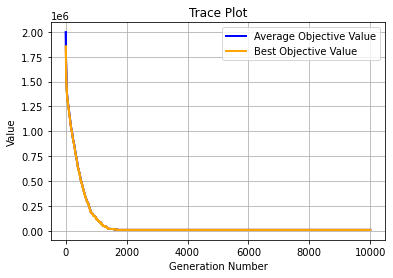

Execution time: 55.381675004959106 s
Evaluation number: 1000000
The best objective value is: 8206.0
The best variables are: 
0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0	0

In [16]:
# soea_SEGA_templet
selectedPackage = DEMO()

#### Output

In [17]:
print('Time Consumption: ', np.round(selectedPackage['executeTime'], decimals=2), 's')
print(selectedPackage['stopMsg'])

if selectedPackage['success']:
    print('Algorithm Succeeded!')
    print('===================================================================================================')
    print('Optimal Target Value: ', np.round(selectedPackage['ObjV'].item(), decimals=2))
    print('Constraint Violation: ', np.round(selectedPackage['CV'][0], decimals=2))
    if debug:
        # TODO: doing
        print('===================================================================================================')
        Vars = selectedPackage['Vars'][0]
        
        data.drop(['FleetAge1', 'FleetAge2', 'FleetAge3', 'Status', 'WeightedAge1', 'WeightedAge2', 'WeightedAge3', 'ProductType1', 'ProductType2', 'ProductType3', 'Lessee1', 'Lessee2', 'Lessee3', 'ContractType1', 'ContractType2', 'ContractType3'], axis=1, inplace=True)
        data.insert(loc=0, column="selected", value=Vars)
        data.to_csv('demo_result.csv')
else:
    print('No Feasible Results...')

Time Consumption:  55.38 s
The algotirhm stepped because it exceeded the generation limit.
Algorithm Succeeded!
Optimal Target Value:  8206.0
Constraint Violation:  [-1.71784000e+03 -9.99932822e+07 -3.20600000e+03 -9.99917940e+07]
